In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


These are the guys making our future LOL. Jason is a dumbass himbo, Sacks is self-interested with a dark pro-Putin vision. Chamath, the SPAC king is a purely self-interested scam artist. Altman is less of a dummy than the 3 twit amigos but we're not prepared for what he has unleashed.

name 'httplib' is not defined


[Sam Altman on the All-In Podcast.](https://podscripts.co/podcasts/all-in-with-chamath-jason-sacks-friedberg/in-conversation-with-sam-altman) - podscripts

___

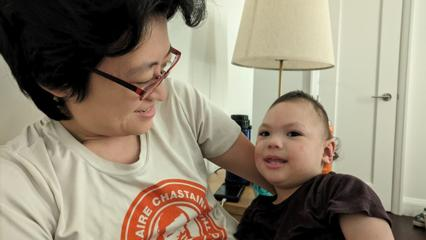

[Could AI make a custom drug just for you?](https://www.statnews.com/2024/05/13/ai-custom-nof1-drugs-new-study/) - STAT

___

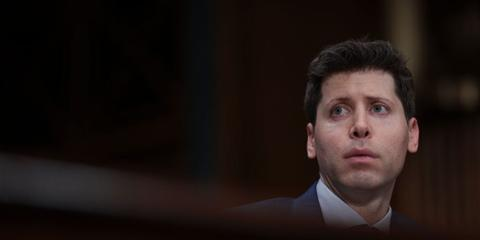

[Universal basic compute sounds half-baked, but I guess it links the value of a UBI to how much human labor gets commoditized. To the extent the value of your labor gets reduced, you get computer/robot labor to replace it.](https://www.businessinsider.com/openai-sam-altman-universal-basic-income-idea-compute-gpt-7-2024-5) - Business Insider

___

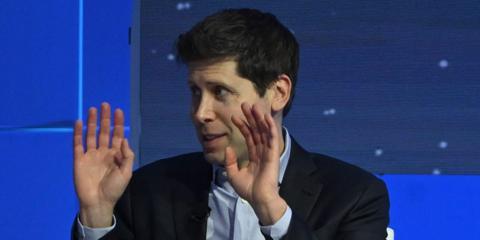

[Sam Altman calls for an international AI agency. Which is not crazy, to harmonize regulation of e.g. autonomous vehicles and aircraft, personal data and privacy, deepfakes, advertising and propaganda, human-rights-related stuff like facial recognition, AI-controlled weapons, AI-created WMDs etc.](https://www.businessinsider.com/sam-altman-openai-artificial-intelligence-regulation-international-agency-2024-5) - Business Insider

___

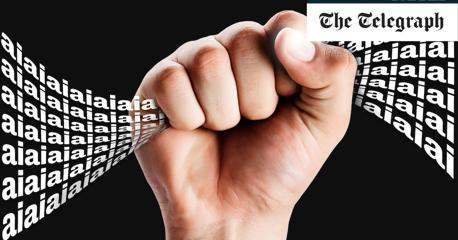

[An Apollo program needs a goal that captures the imagination, like putting a man on the moon. I'm even not sure what you do with a \\$100b AI cloud. 

If fusion proved out, decarbonizing the world's electric grid and transportation network in non-proliferating way would be a great goal.](https://www.telegraph.co.uk/business/2024/05/05/ai-boom-nuclear-power-electricity-demand/) - The Telegraph

___

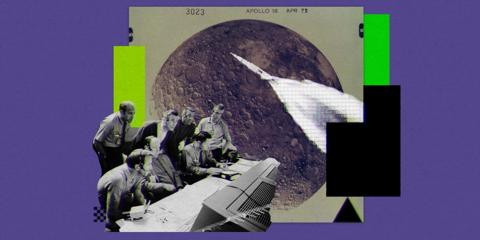

[Eric Schmidt says Feds should build a large government-funded AI research cloud.](https://www.technologyreview.com/2024/05/13/1092322/why-america-needs-an-apollo-program-for-the-age-of-ai/) - MIT Technology Review

___

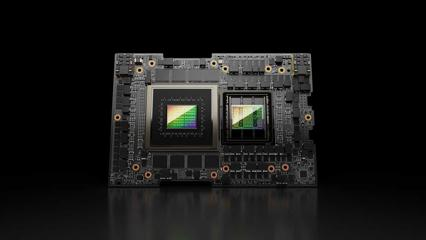

[Nvidia teases quantum CUDA-Q AI.](https://www.networkworld.com/article/2102436/nvidia-teases-quantum-accelerated-supercomputers.html) - Network World

___

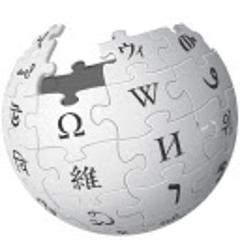

[Wikipedia adds an LLM-powered Chrome extension for fact-checking.](https://chromewebstore.google.com/detail/wikipedia-citation-needed/kecnjhdipdihkibljeicopdcoinghmhj?pli=1)

___

Also improved AI studio dev tools. 

I wonder if OpenAI should release a small local open source model and runtime environment for finetuning it. That space is buzzing but the technical bar to get into it is high for most people.

Top guesses according to Perplexity
- Something with agents and improvements to Assistants API
- Better voice assistant
- Project Q
- Not GPT-5 said Sam Altman, but maybe 4.5 with a long context and multimodality to catch up to Google, and price reductions for GPT-4 matching cheaper startups

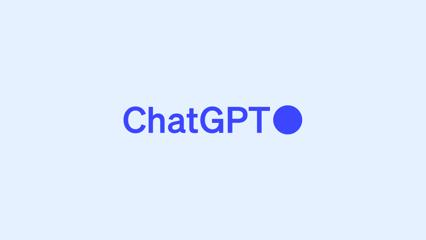

[AI is not yet very good at making, an AI walks into a bar jokes](https://chat.openai.com/share/ed61fac8-3941-496e-b9b3-addc7e6ce6ff)

___

[I don't usually post these sorts of links but I'll make an exception, because screw Rupert Murdoch archive.is/zycY0](https://archive.is/zycY0)

___

[WSJ covers NYC AI startups in NYC like HuggingFace, Runway, Pinecone](https://www.wsj.com/articles/ai-startups-are-making-their-home-in-new-york-can-they-turn-it-into-an-aipowerhouse-bd5dab78)

___

[How did that robot commencement speaker work out? Looks kinda weird and creepy.](https://www.perplexity.ai/search/dyouvilles-robot-commencement-moxfcMtlRgmHLchZe7NpvQ)

___

[Alibaba leverages cloud business to become leading AI startup investor in China.](https://www.ft.com/content/978687d4-f9cf-4990-94b6-8d4f21c5e94b)

___

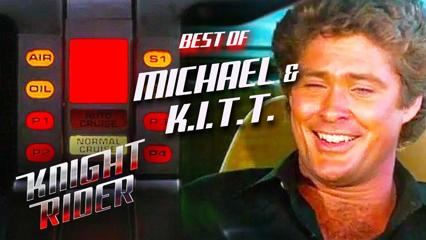

[If OpenAI doesn't put the voice of KITT on their voice search assistant I don't want to hear about it](https://www.youtube.com/watch?v=EE8NQtFaWUY) - YouTube

___

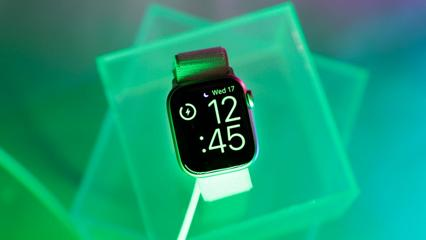

[Really, your phone just needs a lapel pin the size of a button to see and hear what you are doing better and answer questions like, "what painting is this", or "where are my keys?"](https://www.cnet.com/tech/mobile/instead-of-new-ai-gadgets-i-want-smarter-smartwatches/) - CNET

___

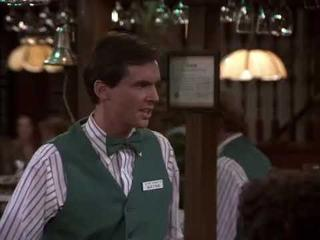

[or, a "Screaming Viking"](https://www.youtube.com/watch?v=eMsDWvDoIm8) - YouTube

___

An AI walks into a bar. 

The bartender says, ""What are you in the mood for tonight?"

The AI looks around the room at what everyone else is having, then orders a nonexistent drink, like a Grey Russian.

[Watching your old journalism job and paper get replaced by an AI pink slime machine.](https://www.sfchronicle.com/opinion/article/ai-journalism-news-job-19449571.php)

___

[Researchers test AI systems' ability to solve the New York Times' connections puzzle](https://techxplore.com/news/2024-05-ai-ability-york-puzzle.html)

___

either they have poor opsec or are good at getting attention with headfakery.

[OpenAI removed 'our most advanced' from the description of GPT-4 ... a more advanced 4.5 or something coming?](https://www.reddit.com/r/ChatGPT/comments/1cpk4g4/openai_changes_gpt4_description_from_our_most/)

___

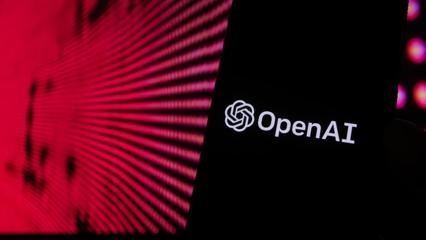

[Wow, a sarcasm detector. Great job, Einsteins.](https://www.pcmag.com/news/openais-assistant-might-soon-be-able-to-detect-sarcasm) - PCMAG

___

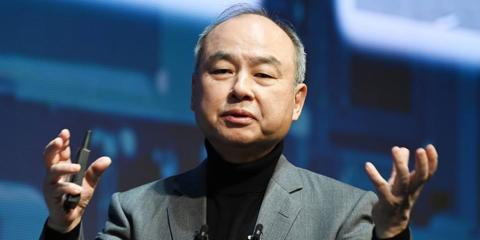

[ARM to launch AI chips to compete with Nvidia. But their business model is they don't sell chips, they license designs to vendors like Apple and Amazon and Nvidia, so this is new for them. Might have pricing power and ways to capture more of the value chain, also might push customers to e.g. RISC-V](https://asia.nikkei.com/Business/Technology/SoftBank-s-Arm-plans-to-launch-AI-chips-in-2025) - Nikkei Asia

___

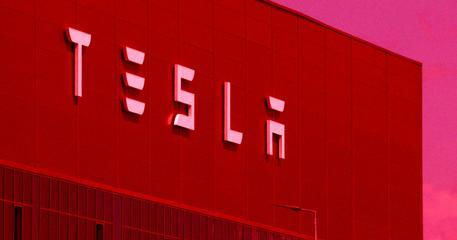

[Tesla exec leaves, suggests it's a toxic work environment and "The recent layoffs that are rocking the company and its morale have thrown this harmony out of balance and it's hard to see the long-game."](https://futurism.com/the-byte/tesla-exec-quits-linkedin-post) - Futurism

___

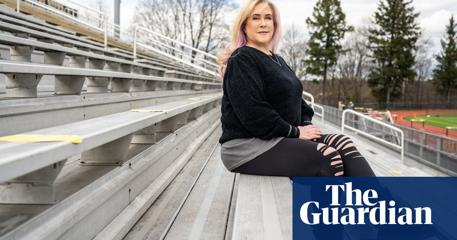

[Videos of cheerleaders engaging in off-limits activities were circulated. The cheerleaders and cops said they were deepfakes. A woman was accused of deepfaking them. Spoiler, they probably weren't deepfakes.](https://www.theguardian.com/technology/article/2024/may/11/she-was-accused-of-faking-an-incriminating-video-of-teenage-cheerleaders-she-was-arrested-outcast-and-condemned-the-problem-nothing-was-fake-after-all) - the Guardian

___

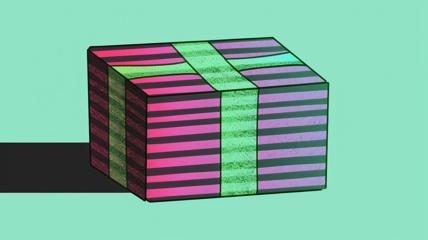

[More rumors of what ChatGPT might show.](https://the-decoder.com/chatgpt-gets-major-upgrades-including-new-voice-features-agents-and-a-new-interface/) - THE DECODER

___

[Maybe we overestimate the impact of AI in the short run but underestimate the impact in the long run?](https://www.bloomberg.com/news/newsletters/2024-05-10/openai-coo-says-it-s-too-soon-to-see-ai-s-full-impact-on-economy)

___

[Maybe the Monday announcement is something about agents, since Altman has been talking that up, or maybe app and voice assistant enhancements, or maybe a grab bag. Early for a new GPT-4 update after April release, or LMSYS phantom models.](https://www.theregister.com/2024/05/11/openai_product_search_monday/)

___

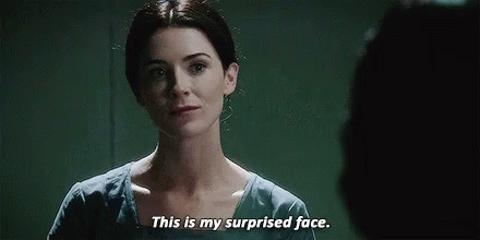

[This is my surprised face](https://tenor.com/view/dottie-underwood-agent-carter-bridget-regan-bridgetsrose-this-is-my-surprised-face-gif-13050543) - Tenor

___

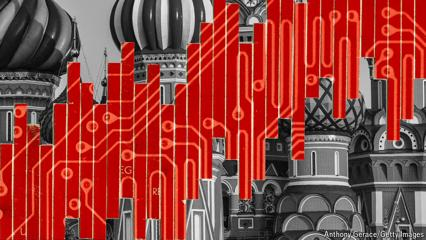

["Please rewrite this article taking a conservative stance against the liberal policies of the Macron administration in favour of working-class French citizens."](https://www.economist.com/science-and-technology/2024/05/10/a-russia-linked-network-uses-ai-to-rewrite-real-news-stories) - The Economist

___

[Waymo is up to 50,000 paid driverless rides per week.](https://www.theinformation.com/briefings/googles-waymo-crosses-50-000-paid-driverless-rides-per-week)

___

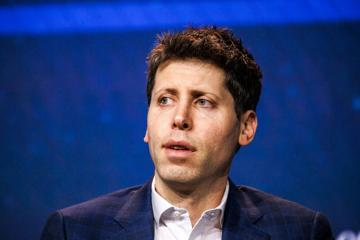

[Sam Altman's SMR fission startup goes public via SPAC. According to ChatGPT their reactors are smaller than NuScale, use more concentrated fuel, don't use water cooling.](https://www.aol.com/news/sam-altman-takes-nuclear-energy-141813704.html)

___

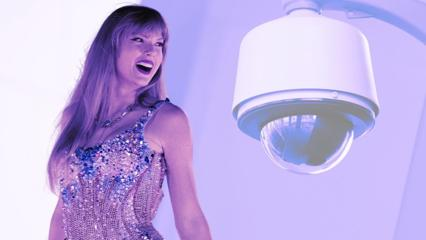

[Paris deploys AI surveillance ahead of Taylor Swift concerts and the Olympics. Says no facial recognition FWIW.](https://www.euronews.com/next/2024/05/10/paris-police-deploys-controversial-ai-powered-video-surveillance-ahead-of-taylor-swift-con) - euronews

___

[Apple nears deal with OpenAI for iOS integration in the new Siri, Google might still be in contention.](https://www.bloomberg.com/news/articles/2024-05-11/apple-closes-in-on-deal-with-openai-to-put-chatgpt-on-iphone)

___

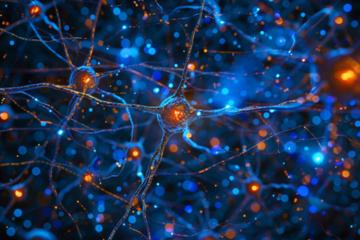

[after losing > \\$20b on stuff like WeWork, FTX, Zume, Katerra, Oyo](https://neurosciencenews.com/neuroscience-generative-ai-26085/) - Neuroscience News

___

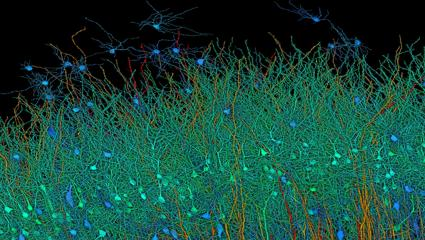

[Researchers scanned a cubic millimeter of brain tissue in 1.4 petabytes, doing a whole brain would take a \\$50b data center.](https://www.tomshardware.com/tech-industry/full-scan-of-1-cubic-millimeter-of-brain-tissue-took-14-petabytes-of-data-equivalent-to-14000-full-length-4k-movies) - Tom's Hardware

___

[SoftBank pivots hard to AI.](https://www.bloomberg.com/news/articles/2024-05-10/softbank-sells-off-vision-fund-assets-as-son-pivots-to-ai-chips)

___

[Apple expected to relaunch Siri at WWDC.](https://www.nytimes.com/2024/05/10/business/apple-siri-ai-chatgpt.html?smid=nytcore-ios-share&referringSource=articleShare&sgrp=c-cb)

___

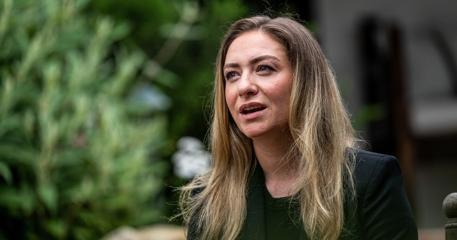

[Bumble founder said some weird stuff.](https://www.nbcnews.com/tech/internet/ai-personas-are-future-dating-bumble-founder-says-many-arent-buying-rcna151738) - NBC News

___

[Adversarial attack makes autonomous vehicles blow through stop signs.](https://www.theregister.com/2024/05/10/baidu_apollo_hack/)

___

[AI film festival suggests it's going mainstream despite misgivings.](https://venturebeat.com/ai/runways-la-film-festival-marked-an-inflection-point-for-ai-movies/)

___

[Las Vegas Sphere plans a new show with AI.](https://www.8newsnow.com/news/local-news/spheres-next-show-to-use-ai-next-big-step-for-las-vegas-exosphere-is-adding-sound/)

___

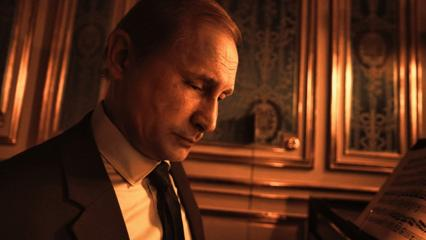

[A Putin biopic with AI and CGI. Could we not?](https://www.hollywoodreporter.com/movies/movie-news/putin-biopic-ai-appetite-1235895731/) - The Hollywood Reporter

___

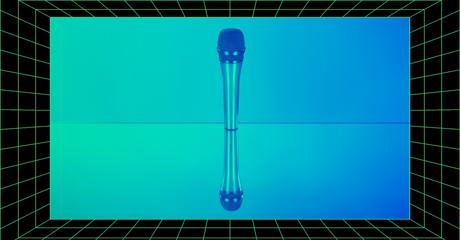

[The Weird World of AI Voice Replicas.](https://www.theatlantic.com/newsletters/archive/2024/05/the-weird-world-of-ai-voice-clones/678353/) - The Atlantic

___

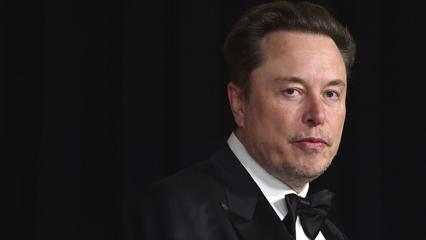

[Elon Musk says that as AI buildout continues, the fraction of the world's intelligence that is human will decline. So, we have that going for us, which is nice.](https://www.euronews.com/next/2024/05/10/elon-musk-predicts-ai-will-overtake-humans-to-the-point-that-biological-intelligence-will-) - euronews

___

[This guy says that just as we don't necessarily consider plants sentient because they move and react so slowly, AI might not consider humans sentient.](https://twitter.com/tsarnick/status/1788701611973329035)

___

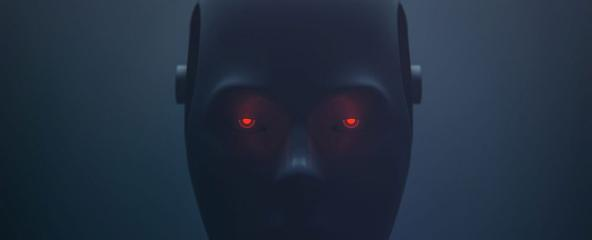

[AI can be strategically lying POS when it wants to.](https://www.sciencealert.com/ai-has-already-become-a-master-of-lies-and-deception-scientists-warn) - ScienceAlert

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 5, 13, 13, 55, 37, 935000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-05-12 03:57:54.031473
